# Seminar 3. Classification


<!-- <font color='red'>**Last updated: 05.02.2024**</font> -->

Necessary libraries and functions.

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline
# Fix the seed and the random state
seed=42
random_state=42

# Binary Classification

Classification is a supervised learning task where the goal is to predict the class or category to which a given data point belongs.

We are given a feature matrix **feature matrix** $X$ and a **target matrix** $Y$:

 $$X = \left( \begin{matrix} x_{1,1} & \dots & x_{1, n} \\ x_{2, 1} & \dots & x_{2, n} \\ \vdots & \ddots & \vdots \\  x_{m,1} & \dots & x_{m, n}  \end{matrix} \right), \qquad Y = \left( \begin{matrix} y_{1} \\  y_{2} \\ \vdots \\ y_{m}  \end{matrix} \right).$$


*   In **classification problems** we want to predict labels that belong to a finite set $y_i \in \left\{0, 1, \dots, K \right\}$.  

If $K = 2$, then it is a **binary classification**. If $K>2$, then it is **Multi-Class Classification**

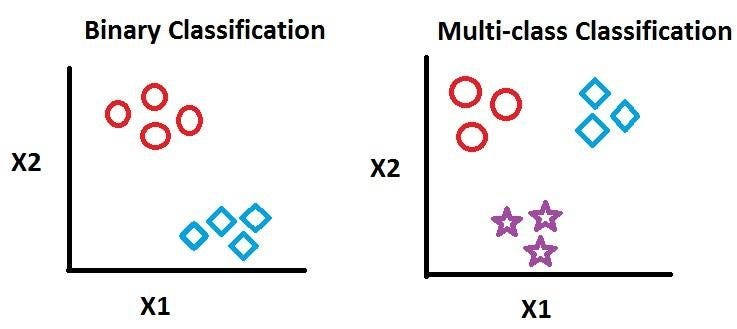

# 1 Quadratic equations

In [2]:
def generate_quadratic_data(n_samples, limit_p=10, limit_q=10):
    p_values = []
    q_values = []
    y_values = []

    for _ in range(n_samples):
        p = np.random.uniform(-limit_p, limit_p)
        q = np.random.uniform(-limit_q, limit_q)

        # Check for real roots using the discriminant
        discriminant = p**2 - 4*q
        y_values.append(1 if discriminant >= 0 else 0) # 1 for real roots, 0 for no real roots
        p_values.append(p)
        q_values.append(q)

    data = pd.DataFrame({'p': p_values, 'q': q_values, 'y': y_values})
    return data

# Generate 3000 quadrics
n_samples = 3000
np.random.seed(42) # Set the random seed for NumPy
data = generate_quadratic_data(n_samples)
print(data.shape)
data.head()

(3000, 3)


,p,q,y
0,-2.509198,9.014286,0
1,4.639879,1.973170,1
2,-6.879627,-6.880110,1
3,-8.838328,7.323523,1
4,2.022300,4.161452,0


Scatter plot of p vs q

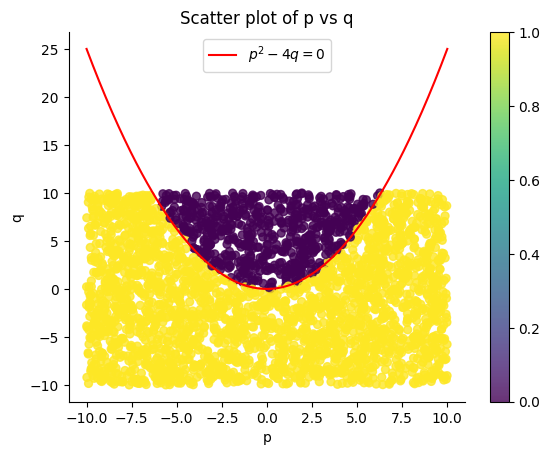

In [3]:
data.plot(kind='scatter', x='p', y='q', s=32, alpha=.8, c=data['y'], cmap='viridis')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Draw the curve p^2 - 4q = 0
p_curve = np.linspace(-10, 10, 400)
q_curve = p_curve**2 / 4
plt.plot(p_curve, q_curve, color='red', label='$p^2 - 4q = 0$')

plt.xlabel('p')
plt.ylabel('q')
plt.title('Scatter plot of p vs q')
plt.legend()
plt.show()

## 1.1. Train-test split

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('y', axis=1)
y = data['y']
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train, 20% test
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3000, 2) (3000,)
(2400, 2) (600, 2) (2400,) (600,)


# 2. Logistic Regression


Let's discuss [Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), a foundational model for classification tasks.

## 2.1 ML model

A simple strategy for solving classification problems involves transforming them into regression problems:

1. **Predict Probabilities:** For each data point $x_i$, the model predicts a probability value, $p_i$ (between 0 and 1), representing the likelihood of that data point belonging to class $1$.  This probability $p_i$ is often referred to as the *predicted probability* or the *class score*.

2. **Apply a Threshold**: A threshold value $T$ (e.g., $0.5$) is chosen. If $p_i \geq T$, then the point $x_i$ is classified as belonging to class $1$.


*   <font color='blue'>**Question:**</font> Linear Regression outputs values across the entire real number line $(-\infty, \infty)$. How can we transform these outputs to a probability value between $0$ and $1$?


A convenient approach is to apply the **sigmoid function**, defined as: $$\sigma(z) = \frac{1}{1 + e^{-z}}, \qquad \sigma(z): \mathbb{R} \to (0, 1).$$

It is a monotonic function with a derivative that is easy to compute: $$\frac{d}{dz} \sigma(z) = \sigma(z) \left( 1 - \sigma(z)\right).$$

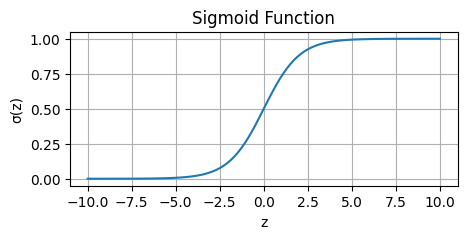

In [5]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

z = np.linspace(-10, 10, 100)  # Create 100 evenly spaced points between -10 and 10
sig = sigmoid(z)

fig = plt.figure(figsize=(5, 2))
plt.plot(z, sig)
plt.xlabel("z")
plt.ylabel("σ(z)")
plt.title("Sigmoid Function")
plt.grid(True)
plt.show()

*   In essence, [Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) can be viewed as a **linear model** followed by a **sigmoid** activation function.


In [6]:
from sklearn.linear_model import LogisticRegression
# Use fit_intercept=False for centered data
reg =  LogisticRegression()

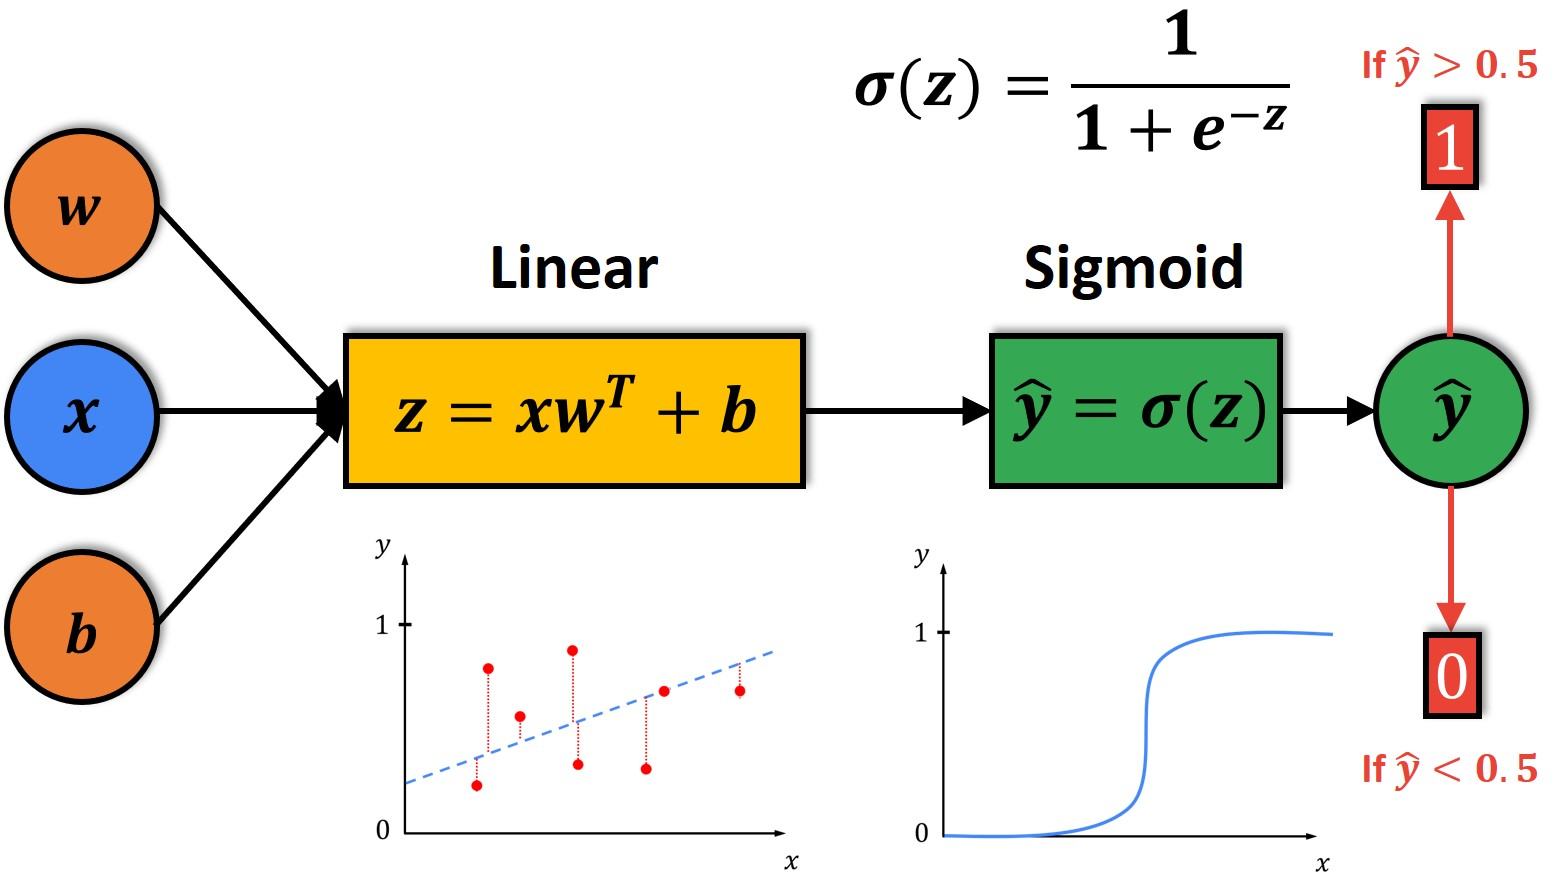

## 2.2 LogLoss


The main loss for a **binary classification** is [LogLoss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html):  

$$L_{\operatorname{log}}(y, p) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right]$$

where:
*  $N$ is the number of samples
*  $y_i$ is the true label ($0$ or $1$) for the $i$-th sample
*  $p_i$ is the predicted probability of the positive class (class $1$) for the $i$-th sample.


In [7]:
from sklearn.metrics import log_loss

*   <font color='blue'>**Question:**</font> Why do we minimize LogLoss?


The goal in binary classification is to find the model that best explains the observed data. Minimizing LogLoss is equivalent to *maximizing the likelihood of the data* under the Bernoulli distribution:  $$L = \operatorname{exp}\left(- m L_{\operatorname{log}}\right) = \prod_{i=1}^n p_i^{y_i} (1-p_i)^{1-y_i}. $$  

## 2.3 Fit-Predict

The general "fit-predict" pipeline for ML models is the same as for the regression problem:

In [8]:
reg.fit(X_train, y_train) # fit the model
y_pred_logloss = reg.predict(X_test) # predictions of the model
loss = log_loss(y_test, y_pred_logloss)
print(f"LogLoss: {loss}")

LogLoss: 7.929603745605773


*   <font color='blue'>**Question:**</font> Are the predictions of our model good?

A simple and intuitive metric is **accuracy**, which measures the percentage of correct predictions: $$\operatorname{Accuracy}(y,y_{\operatorname{pred}})=\frac{1}{m} \sum_{i=0}^{m-1} \mathbb{I}\left[y_i​=f(x_i​)\right].$$

While other evaluation metrics for classification exist (see https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers), we will focus on accuracy for now.

In [9]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_logloss)
print(f"Accuracy: {accuracy}")

Accuracy: 0.78


### 2.3.1 Dummy Models

It's crucial to compare our model's performance against simple baselines. These include the following models:

* Always predict class 0.
* Always predict class 1.
* Randomly predict class 0 or class 1.






In [10]:
# Predictions of all 0
y_pred_all_0 = np.zeros(len(y_test))
# Predictions of all 1
y_pred_all_1 = np.ones(len(y_test))
# Random Predictions
y_pred_random = np.random.randint(0, 2, len(y_test))

data_methods = {
    'Method': ['LogLoss prediction', 'Predictions of all 0',
               'Predictions of all 1', 'Random Predictions'],
    'LogLoss': [
        log_loss(y_test, y_pred_logloss),
        log_loss(y_test, y_pred_all_0),
        log_loss(y_test, y_pred_all_1),
        log_loss(y_test, y_pred_random)
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_logloss),
        accuracy_score(y_test, y_pred_all_0),
        accuracy_score(y_test, y_pred_all_1),
        accuracy_score(y_test, y_pred_random)
    ]
}

df_compare = pd.DataFrame(data_methods)
df_compare

,Method,LogLoss,Accuracy
0,LogLoss prediction,7.929604,0.780000
1,Predictions of all 0,28.955068,0.196667
2,Predictions of all 1,7.088585,0.803333
3,Random Predictions,17.180808,0.523333


As anticipated, Logistic Regression, with its linear decision boundary, struggles to effectively separate data where the true boundary is more complex.

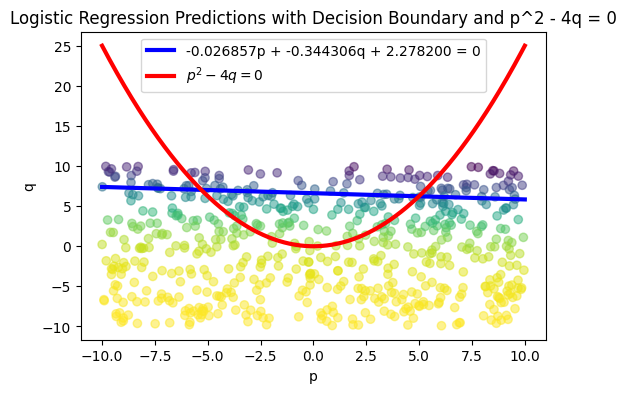

In [11]:
# Plot the decision boundary
plt.figure(figsize=(6, 4))

# Get the predicted probabilities for the positive class
probabilities = reg.predict_proba(X_test)[:, 1]
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], alpha =0.5, c=probabilities, cmap='viridis')

# Coefficients from the logistic regression model
# Replace these with the actual coefficients from your model if different
a, b = reg.coef_[0]
c = reg.intercept_[0]
# Generate x values for the line
p_line = np.linspace(-10, 10, 100)
# Calculate corresponding y values using the equation of the line
q_line = (-a * p_line - c) / b
# Plot the line
plt.plot(p_line, q_line, color='blue',  label=f"{a:.6f}p + {b:.6f}q + {c:.6f} = 0", linewidth=3)

# Plot p^2 - 4q = 0
p_curve = np.linspace(-10, 10, 400)
q_curve = p_curve**2 / 4
plt.plot(p_curve, q_curve, color='red', label='$p^2 - 4q = 0$', linewidth=3)

plt.xlabel('p')
plt.ylabel('q')
plt.title('Logistic Regression Predictions with Decision Boundary and p^2 - 4q = 0')
plt.legend()
plt.show()

## 2.4 Imbalanced datasets

We observe that a simple strategy of predicting a single class achieves high accuracy. This is a clear indicator of **class imbalance** in our dataset, with class 0 representing only about 20% of the data.

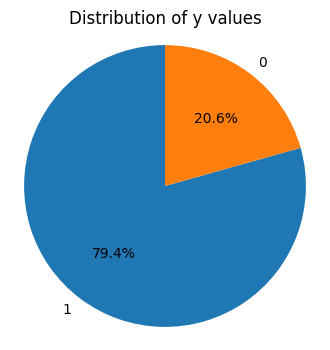

In [12]:
# Count the occurrences of each y value
y_counts = data['y'].value_counts()

# Create the pie chart
plt.figure(figsize=(4, 4))  # Adjust figure size as needed
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of y values')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### 2.4.1 Train-Test split stratification

*   <font color='blue'>**Question:**</font> The standard Train-Test split employs random sampling. Is it a good strategy for imbalanced classes?

Certainly not. In the worst-case scenario, a random split could *result in zero instances* of a particular class within the training set, rendering the model unable to learn from that class.


Here we can see that a standard train-test split can alter the class proportions in the resulting subsets:

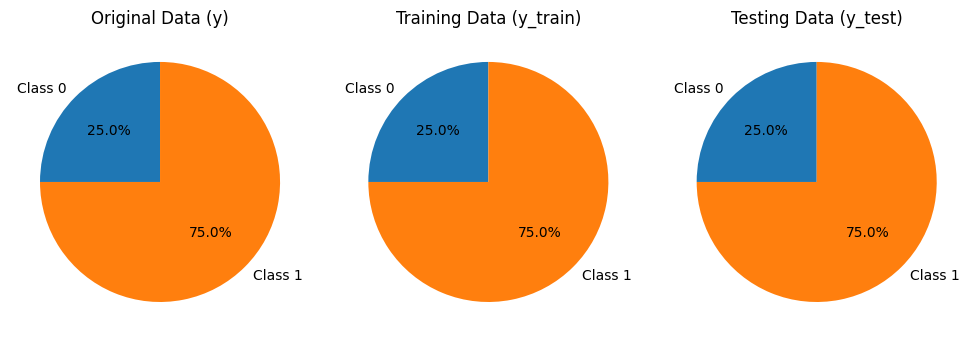

In [13]:
def plot_pies(y, y_train, y_test):
    labels = ['Class 0', 'Class 1']  # Assuming binary classification

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Plot for y
    axes[0].pie([sum(y == 0), sum(y == 1)], labels=labels, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Original Data (y)')

    # Plot for y_train
    axes[1].pie([sum(y_train == 0), sum(y_train == 1)], labels=labels, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Training Data (y_train)')

    # Plot for y_test
    axes[2].pie([sum(y_test == 0), sum(y_test == 1)], labels=labels, autopct='%1.1f%%', startangle=90)
    axes[2].set_title('Testing Data (y_test)')

    plt.tight_layout()
    plt.show()

y_s = np.array([0]*10 + [1]*30)  # 25% Class 0, 75% Class 1
y_train, y_test = train_test_split(y_s, test_size=0.2, stratify=None)
# Example usage (assuming you have y, y_train, y_test defined)
plot_pies(y_s, y_train, y_test)

When splitting data into training and testing sets, we should use Scikit-learn's `stratify` parameter. It ensures that the class proportions are preserved in both subsets.

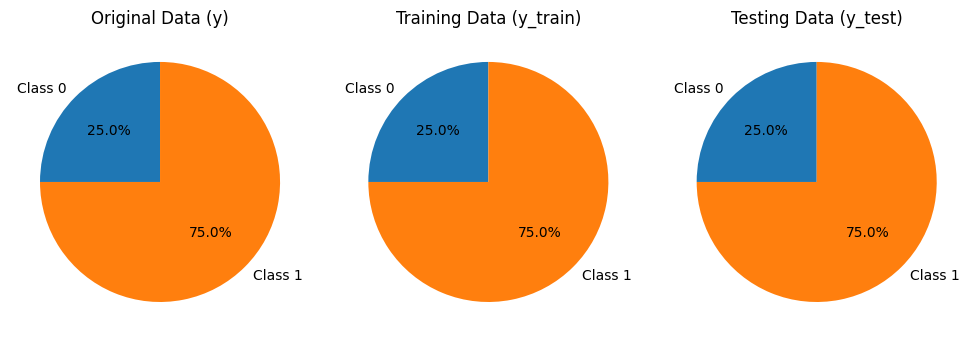

In [14]:



y_train, y_test = train_test_split(y_s, test_size=0.2, stratify=y_s) # 80% train, 20% test

plot_pies(y_s, y_train, y_test)

### 2.4.2 Class Weights

To address class imbalance, we can assign different weights to different classes.

*  Logistic Regression has a `class_weight` parameter. The `balanced` option, a convenient and commonly used choice, automatically adjusts class weights inversely proportional to their frequency.



In [15]:
# Code to update our table with LogLoss and Accuracy:
def update_df_compare(name, df_compare, X_train, X_test, y_train, y_test,
                      class_weight=None):
    # Train a Logistic Regression model on the upsampled data
    model = LogisticRegression(class_weight=class_weight)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # LogLoss
    logloss = log_loss(y_test, y_pred)

    # Calculate the accuracy score for the upsampled model
    accuracy = accuracy_score(y_test, y_pred)

    # Append the new row to the DataFrame
    new_row = {'Method': name,
              'Accuracy': accuracy,
              'LogLoss': logloss}
    df_compare = pd.concat([df_compare, pd.DataFrame([new_row])], ignore_index=True)
    return df_compare

# same as class_weights = 'balanced'
# class_weights = {0: len(y_train[y_train == 0]) / len(y_train), 1: len(y_train[y_train == 1]) / len(y_train)}

# Display the updated DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)
df_compare = update_df_compare('ClassWeights LogReg',
                               df_compare, X_train, X_test,
                               y_train, y_test, class_weight='balanced')
df_compare

,Method,LogLoss,Accuracy
0,LogLoss prediction,7.929604,0.780000
1,Predictions of all 0,28.955068,0.196667
2,Predictions of all 1,7.088585,0.803333
3,Random Predictions,17.180808,0.523333
4,ClassWeights LogReg,8.229968,0.771667


## 2.5 Feature Engineering

While it's somewhat discouraging that a simple dummy predictor currently outperforms our model, this situation can be addressed through **feature engineering**. Let's consider polynomial features up to degree 2.

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Assuming X_train, y_train, X_test, y_test are defined from your previous code

# Create a pipeline with polynomial features and logistic regression
degree = 2 # You can adjust the degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LogisticRegression())

# Fit the model to the training data
poly_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = poly_model.predict(X_test)

# Evaluate the model (example using accuracy)
accuracy = accuracy_score(y_test, y_pred)


# You can further evaluate using log_loss or other relevant metrics
logloss = log_loss(y_test, y_pred)

# Append the new row to the DataFrame
new_row = {'Method': "Polynomial LogReg",
          'Accuracy': accuracy,
          'LogLoss': logloss}
df_compare = pd.concat([df_compare, pd.DataFrame([new_row])], ignore_index=True)
df_compare

,Method,LogLoss,Accuracy
0,LogLoss prediction,7.929604,0.780000
1,Predictions of all 0,28.955068,0.196667
2,Predictions of all 1,7.088585,0.803333
3,Random Predictions,17.180808,0.523333
4,ClassWeights LogReg,8.229968,0.771667
5,Polynomial LogReg,0.060073,0.998333


As expected, it completely solved the problem.

However, it's important to note that feature engineering is not limited to just polynomial features. In a broader sense, it includes any transformation or creation of input variables that can help a model better capture the underlying patterns in the data. Examples include:

- **Logarithmic or exponential transformations**
- **Binning or discretizing continuous variables**
- **Interaction terms between different features**
- **Domain-specific aggregations or encodings**
- **Handling missing values in a meaningful way**
- **Creating time-based features (e.g., time since last event)**


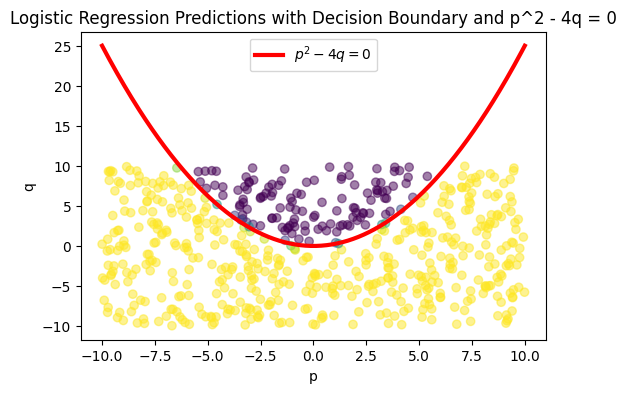

In [17]:
# Plot the decision boundary
plt.figure(figsize=(6, 4))

# Get the predicted probabilities for the positive class
probabilities = poly_model.predict_proba(X_test)[:, 1]
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], alpha =0.5, c=probabilities, cmap='viridis')

# Plot p^2 - 4q = 0
p_curve = np.linspace(-10, 10, 400)
q_curve = p_curve**2 / 4
plt.plot(p_curve, q_curve, color='red', label='$p^2 - 4q = 0$', linewidth=3)

plt.xlabel('p')
plt.ylabel('q')
plt.title('Logistic Regression Predictions with Decision Boundary and p^2 - 4q = 0')
plt.legend()
plt.show()

In [18]:
log_reg = poly_model.named_steps['logisticregression']
log_reg.coef_, log_reg.intercept_

(array([[-4.90311720e-05, -7.60372029e-02, -4.77705325e+00,
          1.29304226e+00,  2.15437547e-02, -4.81035285e-02]]),
 array([-0.42740234]))

### Lasso regularization

Our current model includes many small but non-zero feature weights. The intuition behind using Lasso regularization is that it can drive some of these weights exactly to zero, effectively performing feature selection. Let’s now apply Lasso regularization to our model and observe its impact.

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Assuming X_train, y_train, X_test, y_test are defined from your previous code

# Create a pipeline with polynomial features and logistic regression
degree = 2 # You can adjust the degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree),
                           LogisticRegression(penalty='l1',
                                                                 solver='saga',
                                                                 C=0.3,
                                                                 max_iter=10000)
                           )

# Fit the model to the training data
poly_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = poly_model.predict(X_test)

# Evaluate the model (example using accuracy)
accuracy = accuracy_score(y_test, y_pred)


# You can further evaluate using log_loss or other relevant metrics
logloss = log_loss(y_test, y_pred)

# Append the new row to the DataFrame
new_row = {'Method': "Lasso Polynomial LogReg ",
          'Accuracy': accuracy,
          'LogLoss': logloss}
df_compare = pd.concat([df_compare, pd.DataFrame([new_row])], ignore_index=True)
df_compare

,Method,LogLoss,Accuracy
0,LogLoss prediction,7.929604,0.780000
1,Predictions of all 0,28.955068,0.196667
2,Predictions of all 1,7.088585,0.803333
3,Random Predictions,17.180808,0.523333
4,ClassWeights LogReg,8.229968,0.771667
5,Polynomial LogReg,0.060073,0.998333
6,Lasso Polynomial LogReg,0.060073,0.998333


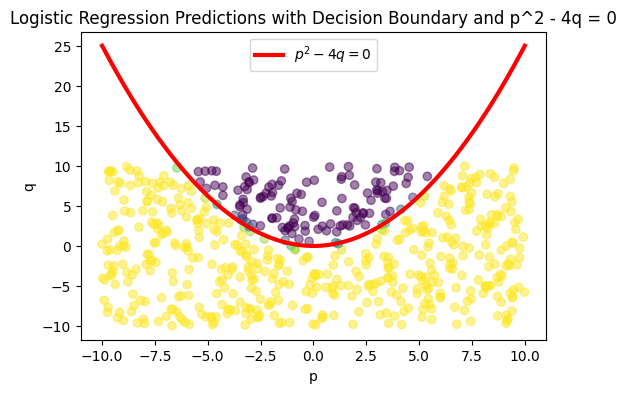

In [20]:
# Plot the decision boundary
plt.figure(figsize=(6, 4))

# Get the predicted probabilities for the positive class
probabilities = poly_model.predict_proba(X_test)[:, 1]
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], alpha =0.5, c=probabilities, cmap='viridis')

# Plot p^2 - 4q = 0
p_curve = np.linspace(-10, 10, 400)
q_curve = p_curve**2 / 4
plt.plot(p_curve, q_curve, color='red', label='$p^2 - 4q = 0$', linewidth=3)

plt.xlabel('p')
plt.ylabel('q')
plt.title('Logistic Regression Predictions with Decision Boundary and p^2 - 4q = 0')
plt.legend()
plt.show()

In [21]:
log_reg = poly_model.named_steps['logisticregression']
log_reg.coef_, log_reg.intercept_

(array([[ 0.        ,  0.        , -3.45410892,  0.9388337 ,  0.00897936,
         -0.03555083]]),
 array([-0.28855417]))

<font color='blue'>**Summary:**</font>

*   *Stratified train-test splits* are crucial, when dealing with imbalanced datasets.
*   Additionally, employing *class weighting* techniques can significantly improve model performance.
*   *Feature engineering* may significantly improve results.
*   *Experiment*!





# 3. **Stochastic gradient descent (SGD)**


The weights of all ML models (that we will use) will be optimized through *gradient-based methods*. By definition, the **gradient** indicates the direction of steepest ascent.

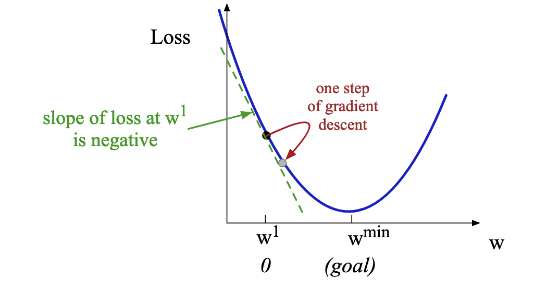

Computing the gradient $$\nabla_{w} L = \sum_{i=1}^m \nabla_{w} L(\hat{y}_i, y_i)$$ for the entire dataset can be computationally demanding. **Stochastic Gradient Descent** (SGD) overcomes this challenge by approximating the true gradient using only a single data point at each iteration: $$w_{t+1} = w_t - \operatorname{lr} \cdot \nabla_{w} L( \hat{y}_i, y_i), \\ \hat{y}_i = f \left(x_i; w \right).$$


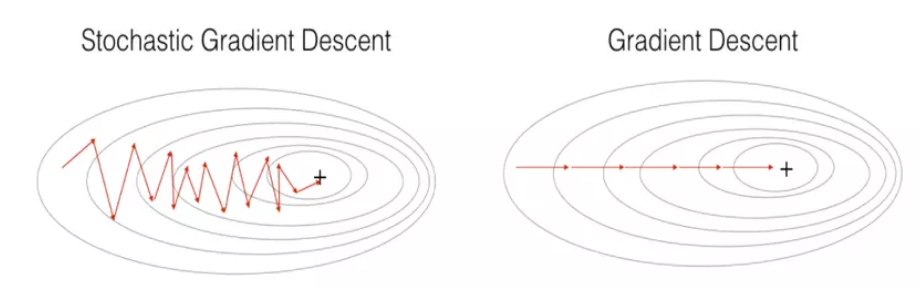

## 3.1 Realization of SGD


Recall the formula for LogLoss:
$$L = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right].$$ It is easy to check that the gradient has the form: $$\nabla_{\mathbf{w}} L =  \left(\sigma(\mathbf{w}\cdot \mathbf{x} + b) - y\right) \cdot \mathbf{x} \\ \nabla_{b} L = \sigma(\mathbf{w}\cdot \mathbf{x} + b) - y.$$

<font color='red'>**Remark (SGDClassifier and LogReg).**</font>
*   SGD is implemented in scikit-learn's [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html). We will leverage SGD for training neural networks.
*   Logistic Regression typically employs more specialized solvers, e.g. `liblinear`, `lbfgs`. For a detailed overview, refer to the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html According to it:
>For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;



In [22]:
from scipy.special import expit  # Sigmoid function

def sgd_with_history(X, y, lr=0.0001, epochs=50, seed=42, shuffle=True, batch_size=1):
    n_features = X.shape[1]
    np.random.seed(seed)
    w = np.random.normal(loc=0, scale=1, size=n_features)
    b = 0
    w_history, b_history = [], []

    for epoch in range(1, epochs + 1):
        # Shuffle the data at the beginning of each epoch
        if shuffle:
            indices = np.random.permutation(len(y))
        else:
            indices = np.arange(len(y))

        # Process mini-batches
        for start_idx in range(0, len(y), batch_size):
            end_idx = start_idx + batch_size
            batch_indices = indices[start_idx:end_idx]

            X_batch = X.iloc[batch_indices]
            y_batch = y.iloc[batch_indices]

            # Predictions: sigmoid(w·x + b)
            z = np.dot(X_batch, w) + b
            preds = expit(z)

            # Compute gradients
            errors = preds - y_batch
            grad_w = np.dot(X_batch.T, errors) / len(y_batch)
            grad_b = np.sum(errors) / len(y_batch)

            # Update weights
            w -= lr * grad_w
            b -= lr * grad_b

            # Save history
            w_history.append(w.copy())
            b_history.append(b)

    return w_history, b_history

## 3.2 Convexity of LogLoss



For Logistic Regression, the *LogLoss function is convex*. A convex function has at most one minimum. Hence a gradient descent starting from any point is guaranteed to find the minimum (if there is one).

In contrast (as we will see later), the non-convex loss function of neural networks can lead to convergence to local minima, trapping the optimization algorithm.

Let's find the optimal parameters $w, b$ for our dataset:

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y) # 80% train, 20% test


# Create and train a Logistic Regression model
logreg = LogisticRegression(random_state=42)

# Fit the model to your training data
logreg.fit(X_train, y_train)

# Optimal Parameters
print("Optimal intercept (bias):", logreg.intercept_)
print("Optimal coefficients (weights):", logreg.coef_)

Optimal intercept (bias): [2.31395244]
Optimal coefficients (weights): [[-0.0162681  -0.34386886]]


## 3.3 Apply SGD

Here we just check that our SGD works on the previous dataset.


In [24]:
def plot_history(X_train, y_train, lr=0.01, epochs=10, x_lim=10, y_lim=10, opt_point=None, batch_size=1, shuffle=True):
    # Call sgd_with_history with new arguments
    w_history, b_history = sgd_with_history(
        X_train, y_train,
        lr=lr,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    # Extract weight trajectory (assumes 2D weights)
    w1_history = [w[0] for w in w_history]
    w2_history = [w[1] for w in w_history]

    plt.figure(figsize=(6, 4))
    plt.plot(w1_history, w2_history, alpha=0.4, label="Path of w")
    plt.scatter(w1_history[-1], w2_history[-1], color='green', alpha=0.6, label="Final point")  # Final point
    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.title("Trajectory of w during SGD")
    plt.grid(True)

    # Plot optimal weights if provided
    if opt_point is not None:
        plt.scatter(opt_point[0, 0], opt_point[0, 1], marker='x', s=100, color='red', label="Optimal point")

    # Set axis limits
    plt.xlim(-x_lim, x_lim)
    plt.ylim(-y_lim, y_lim)
    plt.legend()
    plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_history(X_train, y_train, lr=0.01, epochs=10, x_lim=10, y_lim=10, opt_point=None, batch_size=1, shuffle=True):
    # Run SGD with history
    w_history, b_history = sgd_with_history(
        X_train, y_train,
        lr=lr,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    # Extract w1 and w2 histories (assumes 2D weight vector)
    w1_history = [w[0] for w in w_history]
    w2_history = [w[1] for w in w_history]

    # Create a grid of (w1, w2) values
    w1_vals = np.linspace(-x_lim, x_lim, 100)
    w2_vals = np.linspace(-y_lim, y_lim, 100)
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    Z = np.zeros_like(W1)

    # Compute loss surface
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            w = np.array([W1[i, j], W2[i, j]])
            z = X_train @ w
            preds = 1 / (1 + np.exp(-z))  # Sigmoid
            epsilon = 1e-8  # To avoid log(0)
            loss = -np.mean(y_train * np.log(preds + epsilon) + (1 - y_train) * np.log(1 - preds + epsilon))
            Z[i, j] = loss

    # Plot loss contours
    plt.figure(figsize=(7, 5))
    levels = np.concatenate([
        np.linspace(0.4, 0.7, 20),
        np.linspace(0.71, 2.0, 15)
    ])
    contour = plt.contour(W1, W2, Z, levels=levels, cmap='viridis')
    plt.clabel(contour, inline=1, fontsize=8)

    # Plot trajectory
    plt.plot(w1_history, w2_history, color='blue', alpha=0.5, linewidth=2, label="SGD trajectory")
    plt.scatter(w1_history[-1], w2_history[-1], color='green', label='Final weights')

    # Optional: Plot optimal point
    if opt_point is not None:
        plt.scatter(opt_point[0, 0], opt_point[0, 1], color='red', marker='x', s=100, label='Optimal point')

    # Labels and formatting
    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.title("SGD Weight Trajectory with Loss Contours")
    plt.xlim(-x_lim, x_lim)
    plt.ylim(-y_lim, y_lim)
    plt.grid(True)
    plt.legend()
    plt.show()

We get predictable results:

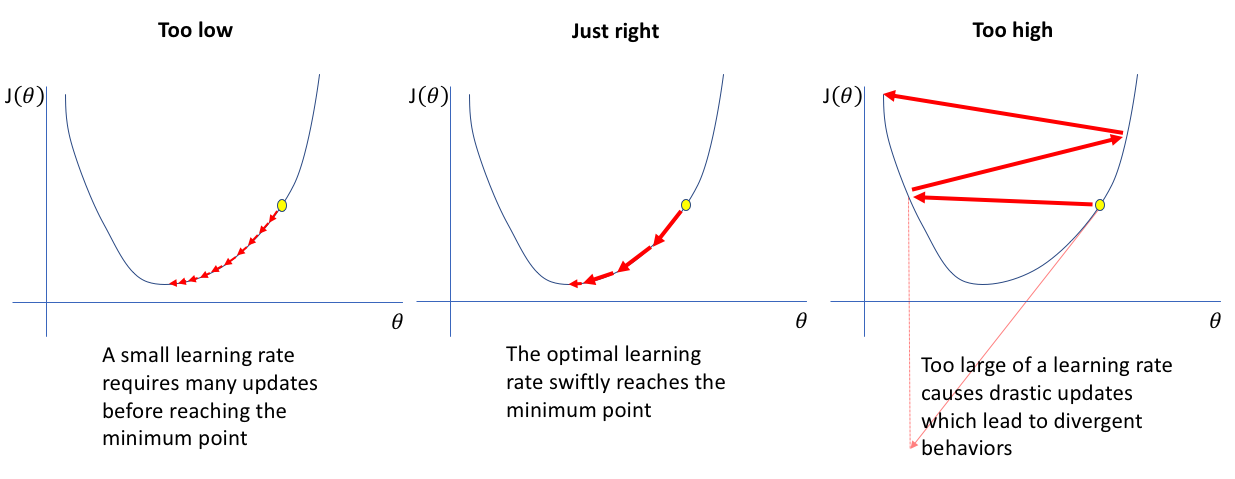

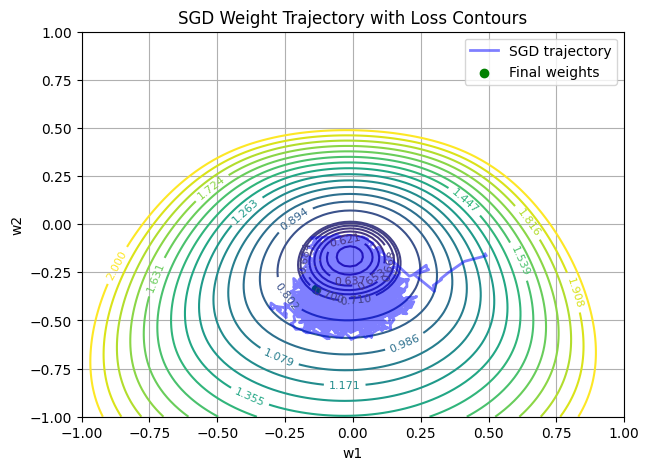

In [26]:
# lr is too big
plot_history(X_train, y_train, lr=0.01, x_lim =1, y_lim =1)

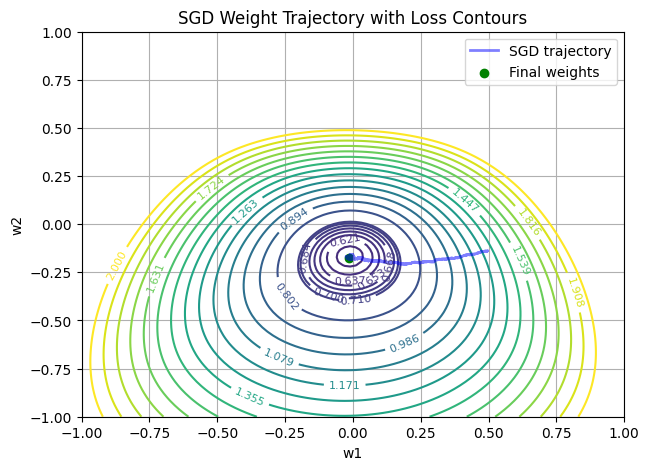

In [27]:
# better lr
plot_history(X_train, y_train, lr=0.0001, x_lim =1, y_lim =1)

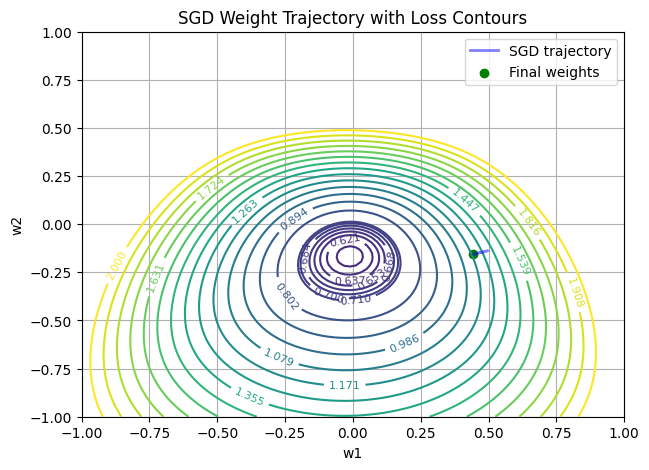

In [28]:
# lr is too small
plot_history(X_train, y_train, lr=0.000001, x_lim =1, y_lim =1)

# 4. Data Standardization

We will now demonstrate the crucial role of **data standardization** by observing its effect on the convergence of gradient descent in a classification setting.


## 4.1 Positive or negative det?

Let us consider a dataset of 10k symmetric matrices $\left(\begin{matrix} a & b \\ b & c \end{matrix} \right).$ We take the numbers uniformly from the following product of intervals $$(a, b, c) \in (-R_a, R_a) \times (-R_b, R_b) \times (-R_c, R_c), \qquad R_a =  10, \qquad R_b = 100, \qquad  R_c = 1.$$

In [29]:
def generate_quadrics(n_samples, range_a, range_b, range_c):
    # Generate data
    a = np.random.uniform(-range_a, range_a, n_samples)
    b = np.random.uniform(-range_b, range_b, n_samples)
    c = np.random.uniform(-range_c, range_c, n_samples)

    # Calculate determinant
    determinant = a * c - b**2

    # Create DataFrame
    data = {'a': a, 'b': b, 'c': c, 'determinant': determinant}
    df = pd.DataFrame(data)
    return df

# Parameters
range_a, range_b, range_c = 10000, 1, 0.0001
n_samples = 10000
df = generate_quadrics(n_samples, range_a, range_b, range_c)
df.head()

,a,b,c,determinant
0,-1800.405482,-0.569013,-0.000042,-0.248913
1,6769.653811,0.289791,0.000060,0.319021
2,-6296.481223,-0.731188,-0.000066,-0.120616
3,1096.843807,0.907951,0.000022,-0.800580
4,4444.665124,0.186030,-0.000090,-0.433422


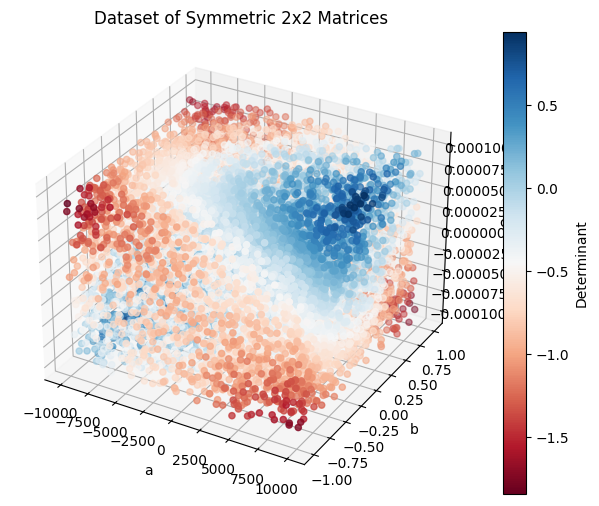

In [30]:
# 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['a'], df['b'], df['c'], c=df['determinant'], cmap='RdBu') # Use RdBu colormap
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c')
ax.set_title('Dataset of Symmetric 2x2 Matrices')

# Add colorbar
plt.colorbar(sc, label='Determinant')

plt.show()

As to be expected the cone $$x^2 + y^2 - z^2 = 0$$ divides the space into three regions

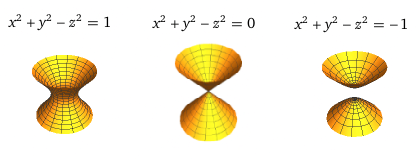

## 4.2 Train-test split

In [31]:
from sklearn.model_selection import train_test_split

X = df.drop('determinant', axis=1)
y = (df['determinant'] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 80% train, 20% test
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 3) (2000, 3) (8000,) (2000,)


The dataset is imbalances:

2 10000


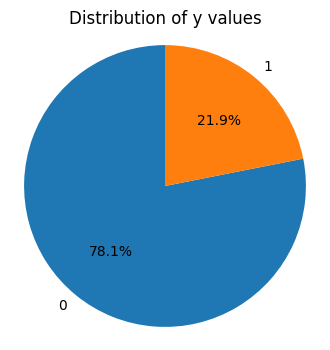

In [32]:
# Count the occurrences of each y value
y_counts = y.value_counts()

print(len(y_counts), sum(y_counts))

# Create the pie chart
plt.figure(figsize=(4, 4))  # Adjust figure size as needed
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of y values')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

First, let's train a Logistic Regression model using polynomial features of degree 2. The accuracy is surprisingly low.

In [33]:
results = []

# Polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train model with polynomial features
logreg_poly = LogisticRegression(solver='liblinear', max_iter=1000)
logreg_poly.fit(X_train_poly, y_train)

y_pred_poly = logreg_poly.predict_proba(X_test_poly)
logloss_poly = log_loss(y_test, y_pred_poly)
accuracy_poly = accuracy_score(y_test, logreg_poly.predict(X_test_poly))

print(f'Accuracy: {accuracy_poly}')

results.append(['Polynomial', logloss_poly, accuracy_poly])
results_df = pd.DataFrame(results, columns=['Method', 'Log Loss', 'Accuracy'])

Accuracy: 0.781


## 4.3 Preprocessing data

Before feeding data into a model, it’s often crucial to preprocess it appropriately. Many machine learning algorithms are sensitive to the **scale and distribution** of input features. If different features vary widely in magnitude, optimization can become inefficient or even ineffective. This is especially relevant for algorithms that rely on **distance metrics**, **gradient descent**, or assume features are on similar scales.

For example, consider the ellipse defined by the constraint:


$x^2 + 100y^2 = 1$


This represents a very elongated ellipse, stretched much more in the $ y $-direction than in the $ x $-direction. If we apply gradient descent starting from a point far from the center, the updates will "zigzag" inefficiently across the narrow dimension, slowing convergence. However, if we first scale $ x $ and $ y $ so that their contributions are balanced — effectively transforming the ellipse into a circle — optimization becomes much more efficient.

To address such issues, we apply preprocessing techniques like:

1. **Standardization.** Normalize data to look like standard normally distributed data: Gaussian with **zero mean and unit variance**.
2. **Scaling features to a range**.  Scale features to lie between a given minimum and maximum value (often between $0$ and $1$) or so that the maximum absolute value of each feature is scaled to unit size.

### 4.3.1 Standardization

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def add_logreg_poly_result(results_df, name, X_train, y_train, X_test, y_test, degree=2):
    # Create a pipeline: standardize → polynomial features → logistic regression
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=degree),
        LogisticRegression(solver='liblinear', max_iter=1000)
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    # Evaluate
    logloss = log_loss(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)

    # Append results
    new_row = {'Method': name,
               'Accuracy': accuracy,
               'Log Loss': logloss}
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    return results_df

# Call the function
results_df = add_logreg_poly_result(results_df, 'Polynomial (Standardized)', X_train, y_train, X_test, y_test)
results_df

,Method,Log Loss,Accuracy
0,Polynomial,0.632860,0.781
1,Polynomial (Standardized),0.034193,0.997


### 4.3.2 Scaling features to a range

In [35]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data and apply polynomial features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results_df = add_logreg_poly_result(results_df, 'Polynomial (Scaled)', X_train_scaled, y_train, X_test_scaled, y_test)
results_df

,Method,Log Loss,Accuracy
0,Polynomial,0.632860,0.781
1,Polynomial (Standardized),0.034193,0.997
2,Polynomial (Scaled),0.034193,0.997


Now, after normalization, the accuracy is much better!

### 4.4 Fit Scaler only on Train dataset

*   <font color='blue'>**Question:**</font> Is it a good idea to fit the scaler on the complete dataset prior to performing the train-test split?

In [36]:
# scaler.fit_transform(X)  # DON'T DO IT !!!
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

No, this would introduce <font color='red'>**data leakage**</font>. Fitting the scaler on the entire dataset allows the model to *indirectly learn information about the test set*, leading to an overly optimistic performance estimate.

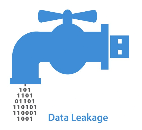

<font color='blue'>**Summary:**</font>

*   Many algorithms require *data standardization*.
*   *Standardize* or *scale features* to a specific range.

# 5. Regularization


Recall that **regularization** involves adding a penalty term to the loss function. A common example is **L2 regularization**: $$\hat{L} = L + \lambda \sum_{\color{red}{j=1}}^m w_j^2.$$

As with classification, **regularization** is highly recommended in the following scenarios:

1. High dimensionality (many features).
2. High feature correlation (near-linear dependencies).
3. Potential overfitting (e.g., complex models, limited data)


Note that [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) by default *includes regularization*.

*   The `hyperparameter 'C'`, which controls the strength of regularization. It is the **inverse of the regularization** strength and must be a positive floating-point value.

The next example shows how excessive regularization can lead to a significant decline in classification accuracy.

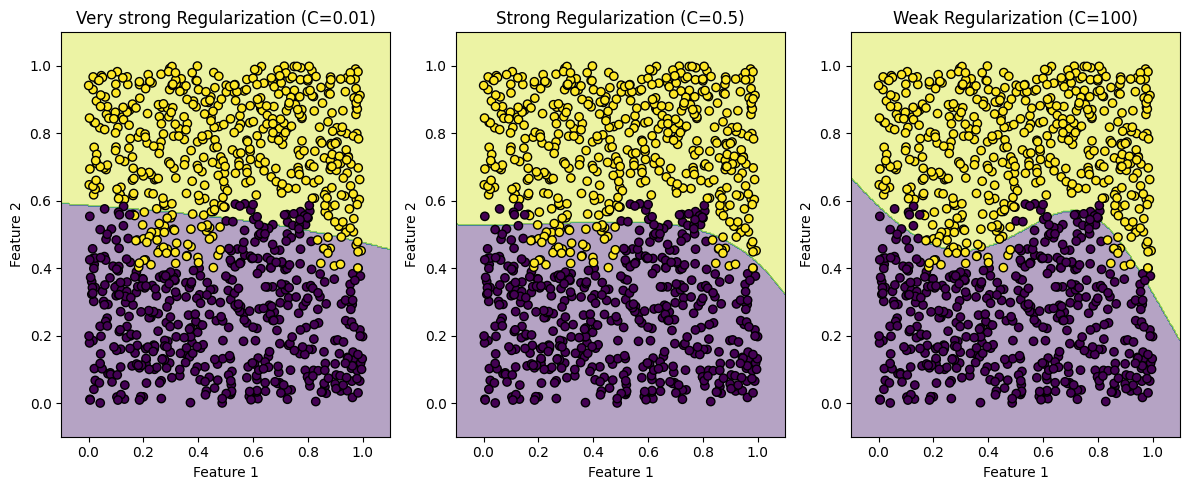

Accuracy (Strong Regularization - C=0.01): 0.90
Accuracy (Weak Regularization - C=100): 0.94


In [59]:
np.random.seed(0)
X = np.random.rand(1000, 2)

def jagged_boundary(x, freq=3, amplitude=0.1):
    x_shifted = x[0] - 0.5
    y_shifted = x[1] - 0.5
    threshold = amplitude * np.sign(np.sin(freq * x_shifted * np.pi))
    return 0 if y_shifted < threshold else 1

y = np.array([jagged_boundary(x) for x in X])
# y = np.array([0 if (x[0] - 0.5)**2 + (x[1] - 0.5)**2 < 0.15 else 1 for x in X])  # circular boundary

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipelines with polynomial features + logistic regression
degree = 7  # Higher degree to allow curvier boundaries

model_strong_reg = make_pipeline(
    PolynomialFeatures(degree),
    LogisticRegression(C=0.5, solver='liblinear', max_iter=1000)
)

model_very_strong_reg = make_pipeline(
    PolynomialFeatures(degree),
    LogisticRegression(C=0.01, solver='liblinear', max_iter=1000)
)


model_weak_reg = make_pipeline(
    PolynomialFeatures(degree),
    LogisticRegression(C=100, solver='liblinear', max_iter=1000)
)

# Fit models
model_very_strong_reg.fit(X_train, y_train)
model_strong_reg.fit(X_train, y_train)
model_weak_reg.fit(X_train, y_train)

# Create a meshgrid for visualization
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict decision boundary
Z_very_strong = model_very_strong_reg.predict(grid).reshape(xx.shape)
Z_strong = model_strong_reg.predict(grid).reshape(xx.shape)
Z_weak = model_weak_reg.predict(grid).reshape(xx.shape)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.contourf(xx, yy, Z_very_strong, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.title("Very strong Regularization (C=0.01)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")


plt.subplot(1, 3, 2)
plt.contourf(xx, yy, Z_strong, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.title("Strong Regularization (C=0.5)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 3, 3)
plt.contourf(xx, yy, Z_weak, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.title("Weak Regularization (C=100)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")



plt.tight_layout()
plt.show()

# Evaluate
acc_strong = accuracy_score(y_test, model_strong_reg.predict(X_test))
acc_weak = accuracy_score(y_test, model_weak_reg.predict(X_test))

print(f"Accuracy (Strong Regularization - C=0.01): {acc_strong:.2f}")
print(f"Accuracy (Weak Regularization - C=100): {acc_weak:.2f}")

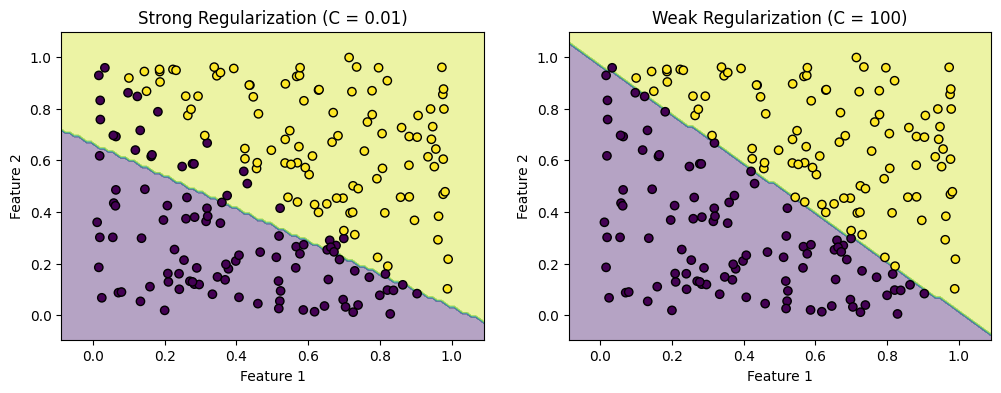

Accuracy (Strong Regularization - C=0.01): 0.85
Accuracy (Weak Regularization - C=100): 0.975


In [38]:
# Generate data for two classes
np.random.seed(0)
X = np.random.rand(200, 2)
y = np.array([0 if x[0] + x[1] < 1 else 1 for x in X])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression with small regularization (C = 0.01)
logreg_small_c = LogisticRegression(C=0.01, solver='liblinear')
logreg_small_c.fit(X_train, y_train)

# Logistic Regression with large regularization (C = 100)
logreg_large_c = LogisticRegression(C=100, solver='liblinear')
logreg_large_c.fit(X_train, y_train)


# Plot the data and decision boundaries
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))


Z_small_c = logreg_small_c.predict(np.c_[xx.ravel(), yy.ravel()])
Z_small_c = Z_small_c.reshape(xx.shape)

Z_large_c = logreg_large_c.predict(np.c_[xx.ravel(), yy.ravel()])
Z_large_c = Z_large_c.reshape(xx.shape)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_small_c, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.title("Strong Regularization (C = 0.01)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_large_c, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.title("Weak Regularization (C = 100)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")


plt.show()

# Calculate accuracy for small regularization
accuracy_small_c = accuracy_score(y_test, logreg_small_c.predict(X_test))
print(f"Accuracy (Strong Regularization - C=0.01): {accuracy_small_c}")

# Calculate accuracy for large regularization
accuracy_large_c = accuracy_score(y_test, logreg_large_c.predict(X_test))
print(f"Accuracy (Weak Regularization - C=100): {accuracy_large_c}")


# 6. Multi-class Classification


To adapt binary logistic regression for **multi-class classification**, there are three common approaches:

1. **One-vs-Rest (OvR).** Train $ K $ independent binary classifiers, one for each class, where each classifier learns to distinguish one class from all the others. At inference time, we evaluate all $ K $ classifiers and choose the one with the highest confidence.

2. **One-vs-One (OvO).**  
   In this strategy, we train a binary classifier for **every pair of classes** — that is, $ \binom{K}{2} $ classifiers in total.  
   Each classifier learns to distinguish between two specific classes. At inference time, a **voting scheme** or aggregation of scores is used to determine the final class.  
   This method can be computationally expensive for large $ K $, but can be beneficial when class boundaries are complex and pairwise separability is easier to learn.


3. **Multinomial (Softmax) Logistic Regression.** Learn a single model that jointly handles all classes using a **shared loss function**.  
   Specifically, we learn $ K $ linear functions  
   $
   y_k(x) = \langle x, w_k \rangle + b_k
   $  
   and apply the **softmax** function to their outputs:  
   $
   \operatorname{Softmax}(x_k) = \frac{\exp(x_k)}{\sum_j \exp(x_j)}
   $
   This approach models the conditional probability of each class directly and usually performs better than OvR when classes are not linearly separable.

In our case, we use the third approach — **multinomial logistic regression** — with a single loss function optimized over all classes.


## 6.1 Example: positive index of inertia

Let's generate a dataset of 10,000 3x3 symmetric matrices and compute the **positive index of inertia** for each matrix.

In [39]:
# Generate 10,000 3x3 symmetric matrices
n_matrices = 10000
matrices = []
np.random.seed(42)
for _ in range(n_matrices):
    A = np.random.rand(3, 3)
    A = np.triu(A)  # Upper triangular part
    A = A + A.T - np.diag(A.diagonal()) # Make it symmetric
    matrices.append(A)

# Calculate positive index of inertia
positive_inertia = []
for matrix in matrices:
  w, v = sla.eig(matrix)
  positive_inertia.append(np.sum(w > 0))

# Create DataFrame
df = pd.DataFrame({'matrix': matrices, 'positive_inertia': positive_inertia})
print(df.shape)
df.head()

(10000, 2)


,matrix,positive_inertia
0,"[[0.3745401188473625, 0.9507143064099162, 0.73...",2
1,"[[0.7080725777960455, 0.020584494295802447, 0....",2
2,"[[0.43194501864211576, 0.2912291401980419, 0.6...",2
3,"[[0.5142344384136116, 0.5924145688620425, 0.04...",2
4,"[[0.3046137691733707, 0.09767211400638387, 0.6...",2


Pie chart of classes:

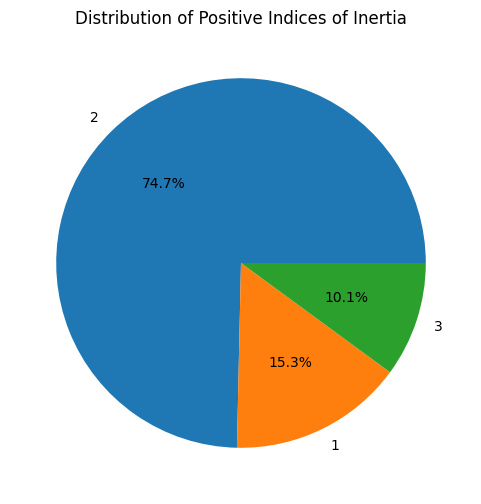

In [40]:
plt.figure(figsize=(6, 6))
df['positive_inertia'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Positive Indices of Inertia')
plt.ylabel('')
plt.show()

### 6.1.1 Data Preprocessing

Dataset for classification:

In [41]:
# Prepare data for logistic regression
X = np.array([matrix.flatten() for matrix in matrices])
y = np.array(positive_inertia)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 9) (2000, 9) (8000,) (2000,)


Polynomial features (up to degree 2):

In [42]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

Standardize the data

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

## 6.2 Multi-class Logistic Regression

[Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), by default, is designed to handle multi-class classification problems

In [44]:
# Logistic Regression with polynomial features on scaled data
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)

We observe a high level of accuracy with our simple model.



In [45]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9835


We can also see the accuracy for each class:

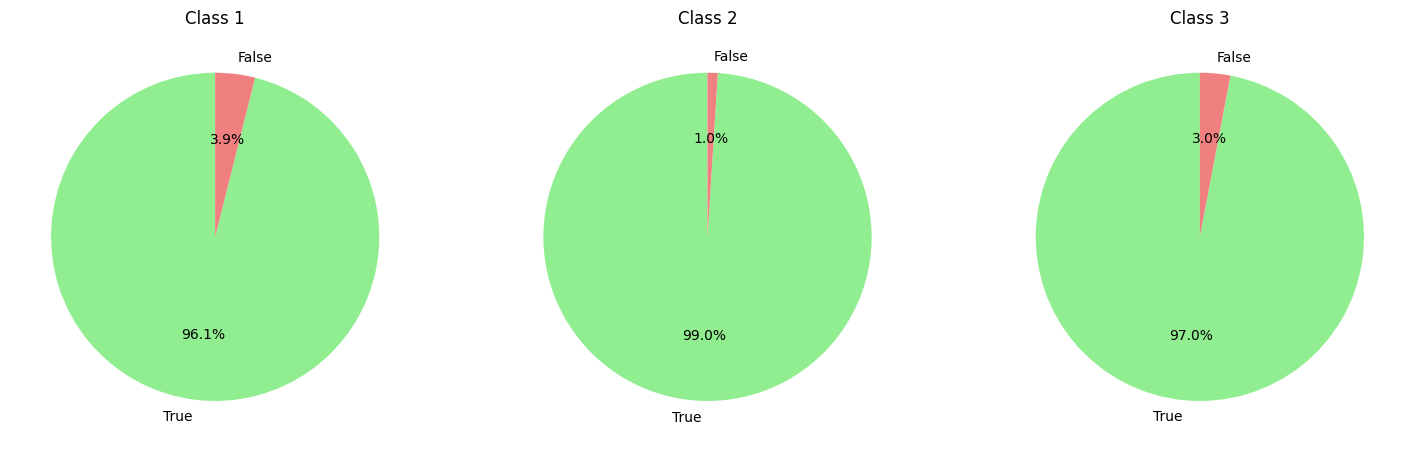

In [46]:
def plot_pie_charts(y_true, y_pred):
    labels = np.unique(y_true)

    fig, axes = plt.subplots(1, len(labels), figsize=(18, 6)) # Adjust figure size as needed

    for i, label in enumerate(labels):
        true_positives = np.sum([(y_true[j] == label) & (y_pred[j] == label) for j in range(len(y_true))])
        total_elements = np.sum([y_true[j] == label for j in range(len(y_true))])

        proportions = [true_positives, total_elements - true_positives]

        axes[i].pie(proportions, labels=['True', 'False'], autopct='%1.1f%%', startangle=90,
                    colors=['lightgreen', 'lightcoral'])
        axes[i].set_title(f"Class {label}")

    plt.show()

plot_pie_charts(y_test, y_pred)

# 7 Some problems with mathematical datasets

Certain mathematical datasets can present challenges for classification algorithms.


> For instance, if a particular class has <font color='red'>a measure of zero</font>  in the feature space, effective classification becomes impossible.



<font color='blue'>**Example:**</font> classify matrices based on their Jordan Normal Form (JNF) or whether they are diagonalizable.

<font color='blue'>**Question (for discussion):**</font> How can we generate a representative dataset for this classification problem? Is it even possible?